# PROTOTYPE OF FINAL PROJECT

In [1]:
#IMPORTS

import pandas as pd
import datetime
import seaborn as sns
import requests
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
#GETTING CURRENCY RATES

def currency_converter():

    APIkey = "j4YVbY4DsPe2bRdqchwWzvccCljEhg2EhlPyfrEN"
    url = f"https://api.freecurrencyapi.com/v1/latest?apikey={APIkey}"
    response = requests.get(url).json()
    df = pd.DataFrame(response['data'], index=[0])
    return df

currency_converter()

,AUD,BGN,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,...,PHP,PLN,RON,RUB,SEK,SGD,THB,TRY,USD,ZAR
0,1.493637,1.867291,5.235649,1.365095,0.942015,6.996148,23.238091,7.106238,0.955433,0.824367,...,55.881227,4.481577,4.695386,60.551458,10.415155,1.358734,35.090356,18.632194,1,17.331527


In [3]:
#GETTING FEAR GRID VALUES

def fgindex() -> pd.DataFrame:
    """returns a dataframe of fear and greed index with columns:
    [value],[value_classification],[timestamp],[time_until_update] """

    url = 'https://api.alternative.me/fng/'
    params = {'limit':100000,'date_format':'world'}
    response = requests.get(url,params).json()
    fg = pd.DataFrame(response['data'])
    return fg

fgindex()

,value,value_classification,timestamp,time_until_update
0,29,Fear,07-12-2022,-1670315378
1,25,Extreme Fear,06-12-2022,NaN
2,26,Fear,05-12-2022,NaN
3,26,Fear,04-12-2022,NaN
4,27,Fear,03-12-2022,NaN
...,...,...,...,...
1763,11,Extreme Fear,05-02-2018,NaN
1764,24,Extreme Fear,04-02-2018,NaN
1765,40,Fear,03-02-2018,NaN
1766,15,Extreme Fear,02-02-2018,NaN


In [4]:
! pip install Historic-Crypto
from Historic_Crypto import HistoricalData

In [5]:
#GETTING CLOSING PRICES OF CRYPTO CURRENCY

crypto = 'BTC'

def prices(crypto)-> pd.DataFrame:

    today = datetime.datetime.today().strftime('%Y-%m-%d')
    crypto_df = HistoricalData(f'{crypto}-USD',86400,'2018-01-31-00-00',f"{today}-00-00",verbose = False).retrieve_data()
    return crypto_df

prices(crypto)

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00
Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00
Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00
Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


,low,high,open,close,volume
time,,,,,
2018-02-01,8400.00,10166.25,10099.99,9014.23,38171.970034
2018-02-02,7540.00,9090.08,9014.22,8787.52,52039.268077
2018-02-03,8115.48,9499.00,8787.52,9240.00,23700.985090
2018-02-04,7859.00,9350.00,9227.80,8167.91,24062.181957
2018-02-05,6425.75,8349.16,8167.90,6905.19,59578.698221
...,...,...,...,...,...
2022-12-03,16863.58,17158.42,17094.25,16888.53,14081.450672
2022-12-04,16882.86,17199.99,16889.17,17108.90,16961.108288
2022-12-05,16865.22,17424.59,17108.90,16966.05,33618.451090


In [6]:
def data_cleaning(crypto = 'BTC'):
    '''The function returns a dataframe containing:
    price: the historical crypto price
    index: the Grid/fear index value
    '''
    #cleaning the price data

    BTC_USD = prices(crypto)
    BTC_USD= BTC_USD['close']

    #cleaning the sentiment data
    sentiment_data = fgindex()
    sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
    sentiment_data['value'] = sentiment_data['value'].astype('float')
    fg= pd.DataFrame(sentiment_data[['value', 'timestamp']])
    fg.set_index('timestamp', inplace=True)


    #merging the price and sentiment data
    df = fg.join(BTC_USD)

    #cleaning the merged dataframe
    df.dropna(inplace=True)
    df.rename(columns = {'close': 'price', 'value': 'index'}, inplace = True)

    return df

df = data_cleaning()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00
Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00
Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00
Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


In [7]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
import numpy as np

def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:

# Predict Closing Prices using a 10 day window of fear and greed index values and a target of the 11th day closing price
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [9]:
# Use 70% of the data for training and the remainder for testing

# x split
split = int(.7 * len(X))
X_train = X[:split - 1]
X_test = X[split:]

# y split
y_train = y[:split - 1]
y_test = y[split:]

In [10]:
df.dtypes

index    float64
price    float64
dtype: object

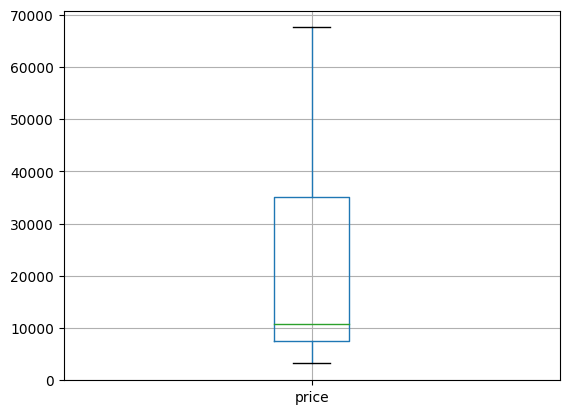

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

boxplot = df.boxplot(column=['price'])


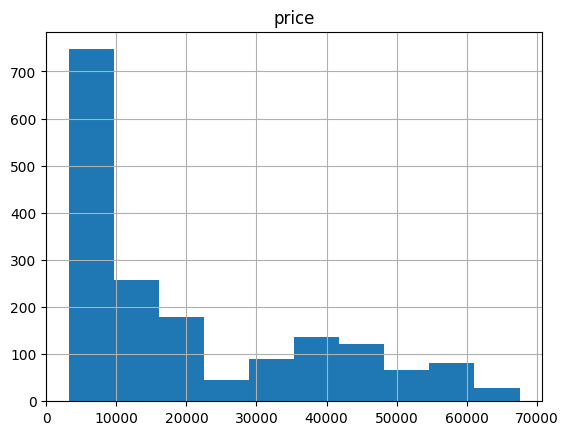

In [12]:
histogram = df.hist(column=['price'])
plt.show()

In [13]:
# Use MinMaxScaler to scale the data between 0 and 1
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [14]:
X_train.shape

(1218, 10)

In [15]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [16]:
X_train.shape

(1218, 10, 1)